# Applying CLIP model

In [1]:
import os
import matplotlib.pyplot as plt
import clip
import torch
from torchvision.datasets import CIFAR100
#from torchvision.datasets import CocoDetection
import numpy as np
import PIL
%matplotlib inline

#Had OpenMPI issue
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%load_ext autoreload
%autoreload 2

## First test with constellation image

In [2]:
# Load constellations
from dataUtils import * 
pictures = loadConstellations(pictureTypes=["original", "final_easy", "outline"])

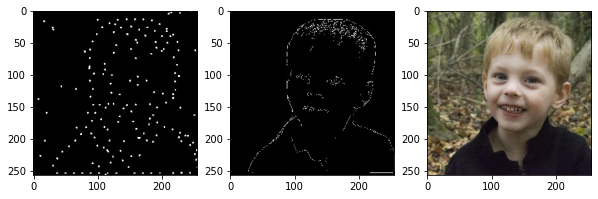

In [3]:
### Visualize selected image and its original
imageIdx = 24
objectId = list(pictures.keys())[imageIdx]
constellationImage = pictures[objectId]["final_easy"][0]
outlineImage = pictures[objectId]["outline"][0]
originalImage = pictures[objectId]["original"][0]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))
ax1.imshow(constellationImage)
ax2.imshow(outlineImage)
ax3.imshow(originalImage)

In [4]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
#Different architectures, choose one
model, preprocess = clip.load('ViT-B/32', device) #Faster
#model, preprocess = clip.load('RN50x4', device) #Better but takes more time


100%|███████████████████████████████████████| 354M/354M [00:58<00:00, 6.06MiB/s]


In [5]:
# Download the dataset (not necessary, as only interested in classes)
#cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)
#Coco = CocoDetection(root=os.path.expanduser("~/.cache"), download=True, train=False)

In [8]:
#Available classifications from different datasets
#combinedClasses.txt - CoCo + CIFAR100 (around 160 classes, removed duplicates)
#combinedClassesAdditional.txt -CoCo + CIFAR100 + classes about pictures which constellations are in set but 
#not in either CoCo or CIFAR100 classes (around 180 classes, removed duplicates)
#cocoClasses.txt - CoCo (80 classes)
#cifarClasses.txt - Cifar100 (100 classes)
#imagenet_classes.txt - Imagenet classes (around 1000 classes)
#things_classes.txt - Imagenet classes (around 1000 classes)

chosenDataset = "things_classes.txt"
# Read the categories
with open(os.path.join("classes",chosenDataset), "r") as f:
    categories = [s.strip() for s in f.readlines()]

object_196
final_easy

Top predictions for final_easy :

       scrambled: 3.08%
       fireworks: 2.85%
            star: 2.21%
        sparkler: 2.14%
        confetti: 2.09%
outline

Top predictions for outline :

       footprint: 3.54%
          mussel: 2.71%
          insole: 2.31%
         tadpole: 2.00%
        snowshoe: 1.74%
original

Top predictions for original :

     hummingbird: 95.87%
            bird: 0.72%
           jewel: 0.34%
         emerald: 0.31%
          roller: 0.27%
object_201
final_easy

Top predictions for final_easy :

          gasket: 1.85%
            star: 1.52%
       scrambled: 1.10%
          caviar: 0.72%
        sparkler: 0.66%
outline

Top predictions for outline :

         penguin: 79.21%
         flipper: 1.30%
          tuxedo: 1.24%
          puffin: 0.47%
          badger: 0.44%
original

Top predictions for original :

         penguin: 72.06%
         flipper: 3.44%
          tuxedo: 2.77%
          puffin: 2.73%
     ticktacktoe: 0.72%

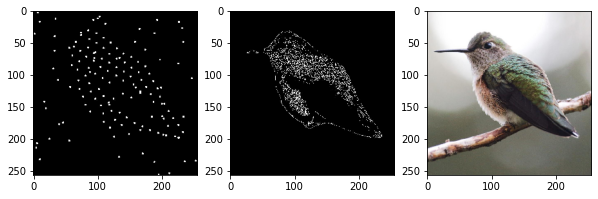

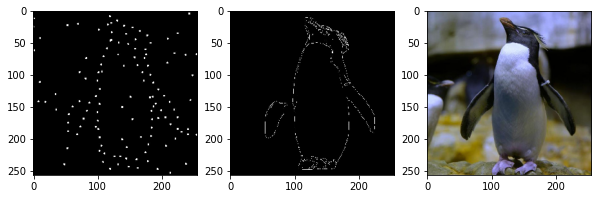

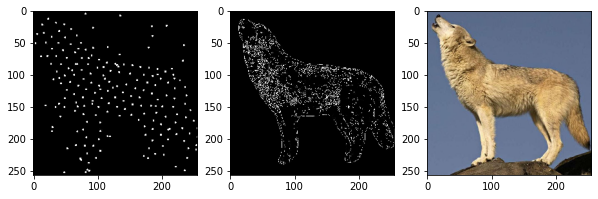

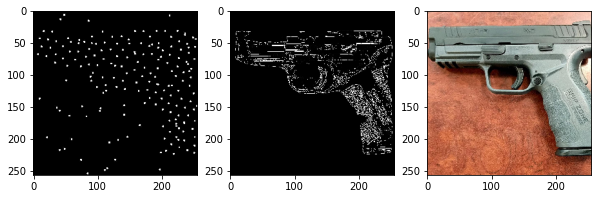

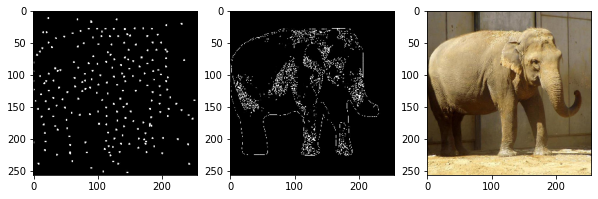

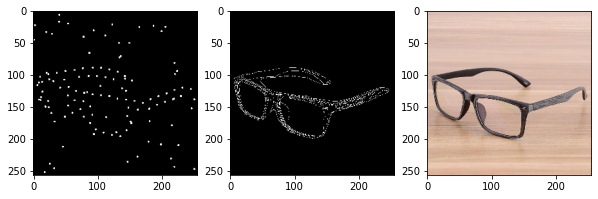

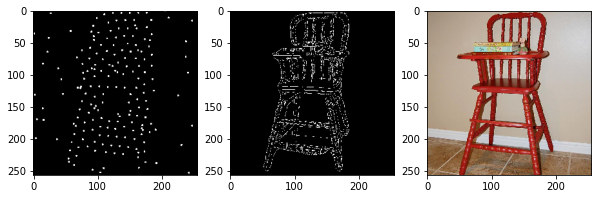

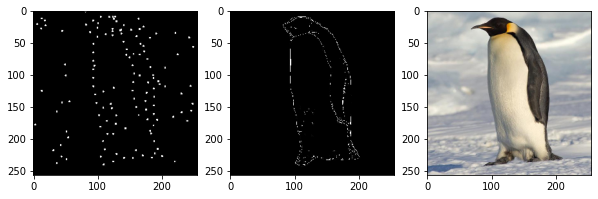

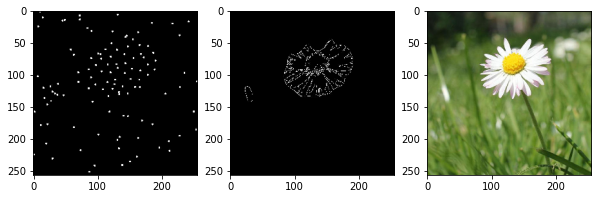

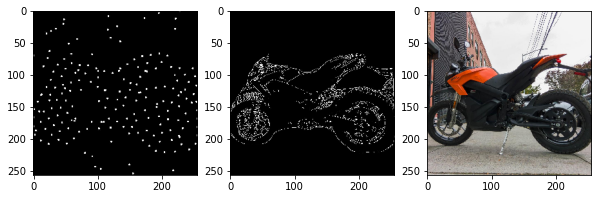

In [9]:
# Prepare the inputs
#image, class_id = cifar100[3637]
n = 10#len(pictures.keys())

for i in range(n):
    objectId = list(pictures.keys())[i]
    constellationImage = pictures[objectId]["final_easy"][0]
    outlineImage = pictures[objectId]["outline"][0]
    originalImage = pictures[objectId]["original"][0]
    print(objectId)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))
    axes[0].imshow(constellationImage)
    axes[1].imshow(outlineImage)
    axes[2].imshow(originalImage)
    plt.show()
    
    for image_type in ["final_easy","outline", "original"]:
        print(image_type)

#    for image_type in ["outline", "final_easy"]:

        image = PIL.Image.fromarray(pictures[objectId][image_type][0])
        image_input = preprocess(image).unsqueeze(0).to(device)
        text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in categories]).to(device)

        # Calculate features
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_inputs)

        # Pick the top 5 most similar labels for the image
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity[0].topk(5)

        # Print the result
        print("\nTop predictions for", image_type, ":\n")
        for value, index in zip(values, indices):
            print(f"{categories[index]:>16s}: {100 * value.item():.2f}%")